# Modelo predictivo para identificar el éxito comercial de productos en la industria de videojuegos


---

---

## Contents

1. [Contexto](#Contexto)
1. [Objetivo](#Objetivo)
1. [Setup](#Setup)
1. [Descargar datos](#Descargar_datos)
1. [Preparar datos](#Preparar_datos)
1. [Entrenamiento](#Entrenamiento)
1. [Deployment](#Deployment)
1. [Evaluacion](#Evaluacion)


## Contexto

En este taller analizaremos la venta de videjuegos y construiremos un modelo para predecir el éxito comercial de un producto en base a la evaluación que ha recibido. Usaremos el dataset [Video Game Sales with Ratings](https://www.kaggle.com/rush4ratio/video-game-sales-with-ratings) de Kaggle, el cual contiene información acerca de videojuegos en múltiples paltaformas, el número de unidades vendidas y los reviews recibidos por la crítica y los usuarios.

El dataset contiene la siguientes columnas:

- Name: Nombre del videojuego
- Platform: Consola o plataforma en la cual fue evaluado
- Year_of_Release: Año en que fue lanzado al mercado
- Genre: Genero
- Publisher: Editor
- NA_Sales: Numero de unidades vendidas en Norte America, expresado en millones
- EU_Sales: Numero de unidades vendidas en Europa
- JP_Sales: Numero de unidades vendidas en Japon
- Other_Sales: Numero de unidades vendidas en el resto del mundo
- Global_Sales: Total del numero de unidades vendidas
- Critic_Score: Evaluación del juego por la crítica. Escala de 1 a 100
- Critic_Count: Número de evaluadores de la crítica
- User_Score: Evaluación del juego por los usuarios. Escala de 1 a 10
- User_Count: Número de usuarios que evaluaron el juego
- Developer: Desarrollador del juego
- Rating: Clasificación ESRB. E: Everyone, E10+: Everyone 10+, M: Mature 17+, A: Adult 18+


## Objetivo

Construir un modelo predictivo que permita identificar si un juego será o no un éxito comercial usando las evaluaciones por parte de la crítica y los usuarios.

En este caso, optaremos por construir un modelo de clasificación.

## Setup


Antes de partir la construcción del modelo, necesitamos ejecutar los siguients pasos,

- Importar algunas librerias de Pytho
- Especficar el bucket de S3 y el prefijo que usaremos para almacenar los datos del entrenamiento
- Definir el rol IAM para tener acceso a los datos de S3


In [1]:
import os
import sys                                        
import math                                       
import json
import requests
import numpy as np                                
import pandas as pd                               

import seaborn as sns
import matplotlib.pyplot as plt   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 

import boto3

sns.set_style('darkgrid')
sns.set_context("talk")

---
## Descargar_datos

Existen multiples maneras de conectarse a la fuente de datos. Aqui veremos dos:

- Libreria requests
- Libreria boto3

El dataset está disponible en este link https://taller-copec.s3.amazonaws.com/data/Kaggle_ventas_videojuegos.csv

In [3]:
dataDir = 'data'
resultsDir = 'results'

if not os.path.exists(dataDir):
    os.makedirs(dataDir)

if not os.path.exists(resultsDir):
    os.makedirs(resultsDir)

Usando requests

In [4]:
dataURL = 'https://taller-copec.s3.amazonaws.com/data/Kaggle_ventas_videojuegos.csv'
dataFile = 'data/Kaggle_ventas_videojuegos.csv'

r = requests.get(dataURL, allow_redirects=True)

open(dataFile, 'wb').write(r.content)

1618040

Usando boto3

In [5]:
bucketName = 'taller-copec'
bucketFileName = 'data/Kaggle_ventas_videojuegos.csv'
localFileName = 'data/Kaggle_ventas_videojuegos.csv'

s3 = boto3.client('s3')
s3.download_file(bucketName, bucketFileName, localFileName)

## Analisis exploratorio datos

Siempre es recomendable hacer un Exploratory data analysis (EDA) para ayudar al entendimiento del dataset. El EDA puede incluir imprimir en pantalla algunos registros, calcular algunas cantidades descriptivas y generar algunas visualizaciones/gráficos.

In [6]:
dataDF = pd.read_csv(dataFile)
dataDF.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
len(dataDF)

16719

In [8]:
dataDF.describe()

,Year_of_Release,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Count
count,16450.000000,16719.000000,16719.000000,16719.000000,16719.000000,16719.000000,8137.000000,8137.000000,7590.000000
mean,2006.487356,0.263330,0.145025,0.077602,0.047332,0.533543,68.967679,26.360821,162.229908
std,5.878995,0.813514,0.503283,0.308818,0.186710,1.547935,13.938165,18.980495,561.282326
min,1980.000000,0.000000,0.000000,0.000000,0.000000,0.010000,13.000000,3.000000,4.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,0.060000,60.000000,12.000000,10.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000,71.000000,21.000000,24.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,0.470000,79.000000,36.000000,81.000000
max,2020.000000,41.360000,28.960000,10.220000,10.570000,82.530000,98.000000,113.000000,10665.000000


In [9]:
dataDF.groupby('Year_of_Release').size()

Year_of_Release
1980.0       9
1981.0      46
1982.0      36
1983.0      17
1984.0      14
1985.0      14
1986.0      21
1987.0      16
1988.0      15
1989.0      17
1990.0      16
1991.0      41
1992.0      43
1993.0      62
1994.0     121
1995.0     219
1996.0     263
1997.0     289
1998.0     379
1999.0     338
2000.0     350
2001.0     482
2002.0     829
2003.0     775
2004.0     762
2005.0     939
2006.0    1006
2007.0    1197
2008.0    1427
2009.0    1426
2010.0    1255
2011.0    1136
2012.0     653
2013.0     544
2014.0     581
2015.0     606
2016.0     502
2017.0       3
2020.0       1
dtype: int64

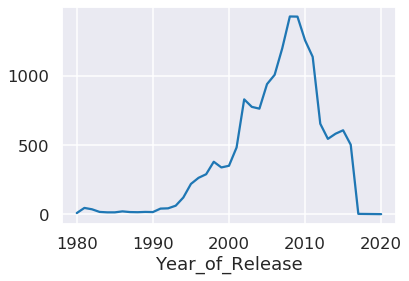

In [10]:
dataDF.groupby('Year_of_Release').size().plot()

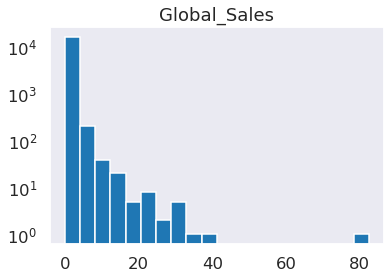

In [11]:
fig, ax = plt.subplots()
dataDF.hist('Global_Sales', bins=20, grid=False, ax=ax)
ax.set_yscale('log')

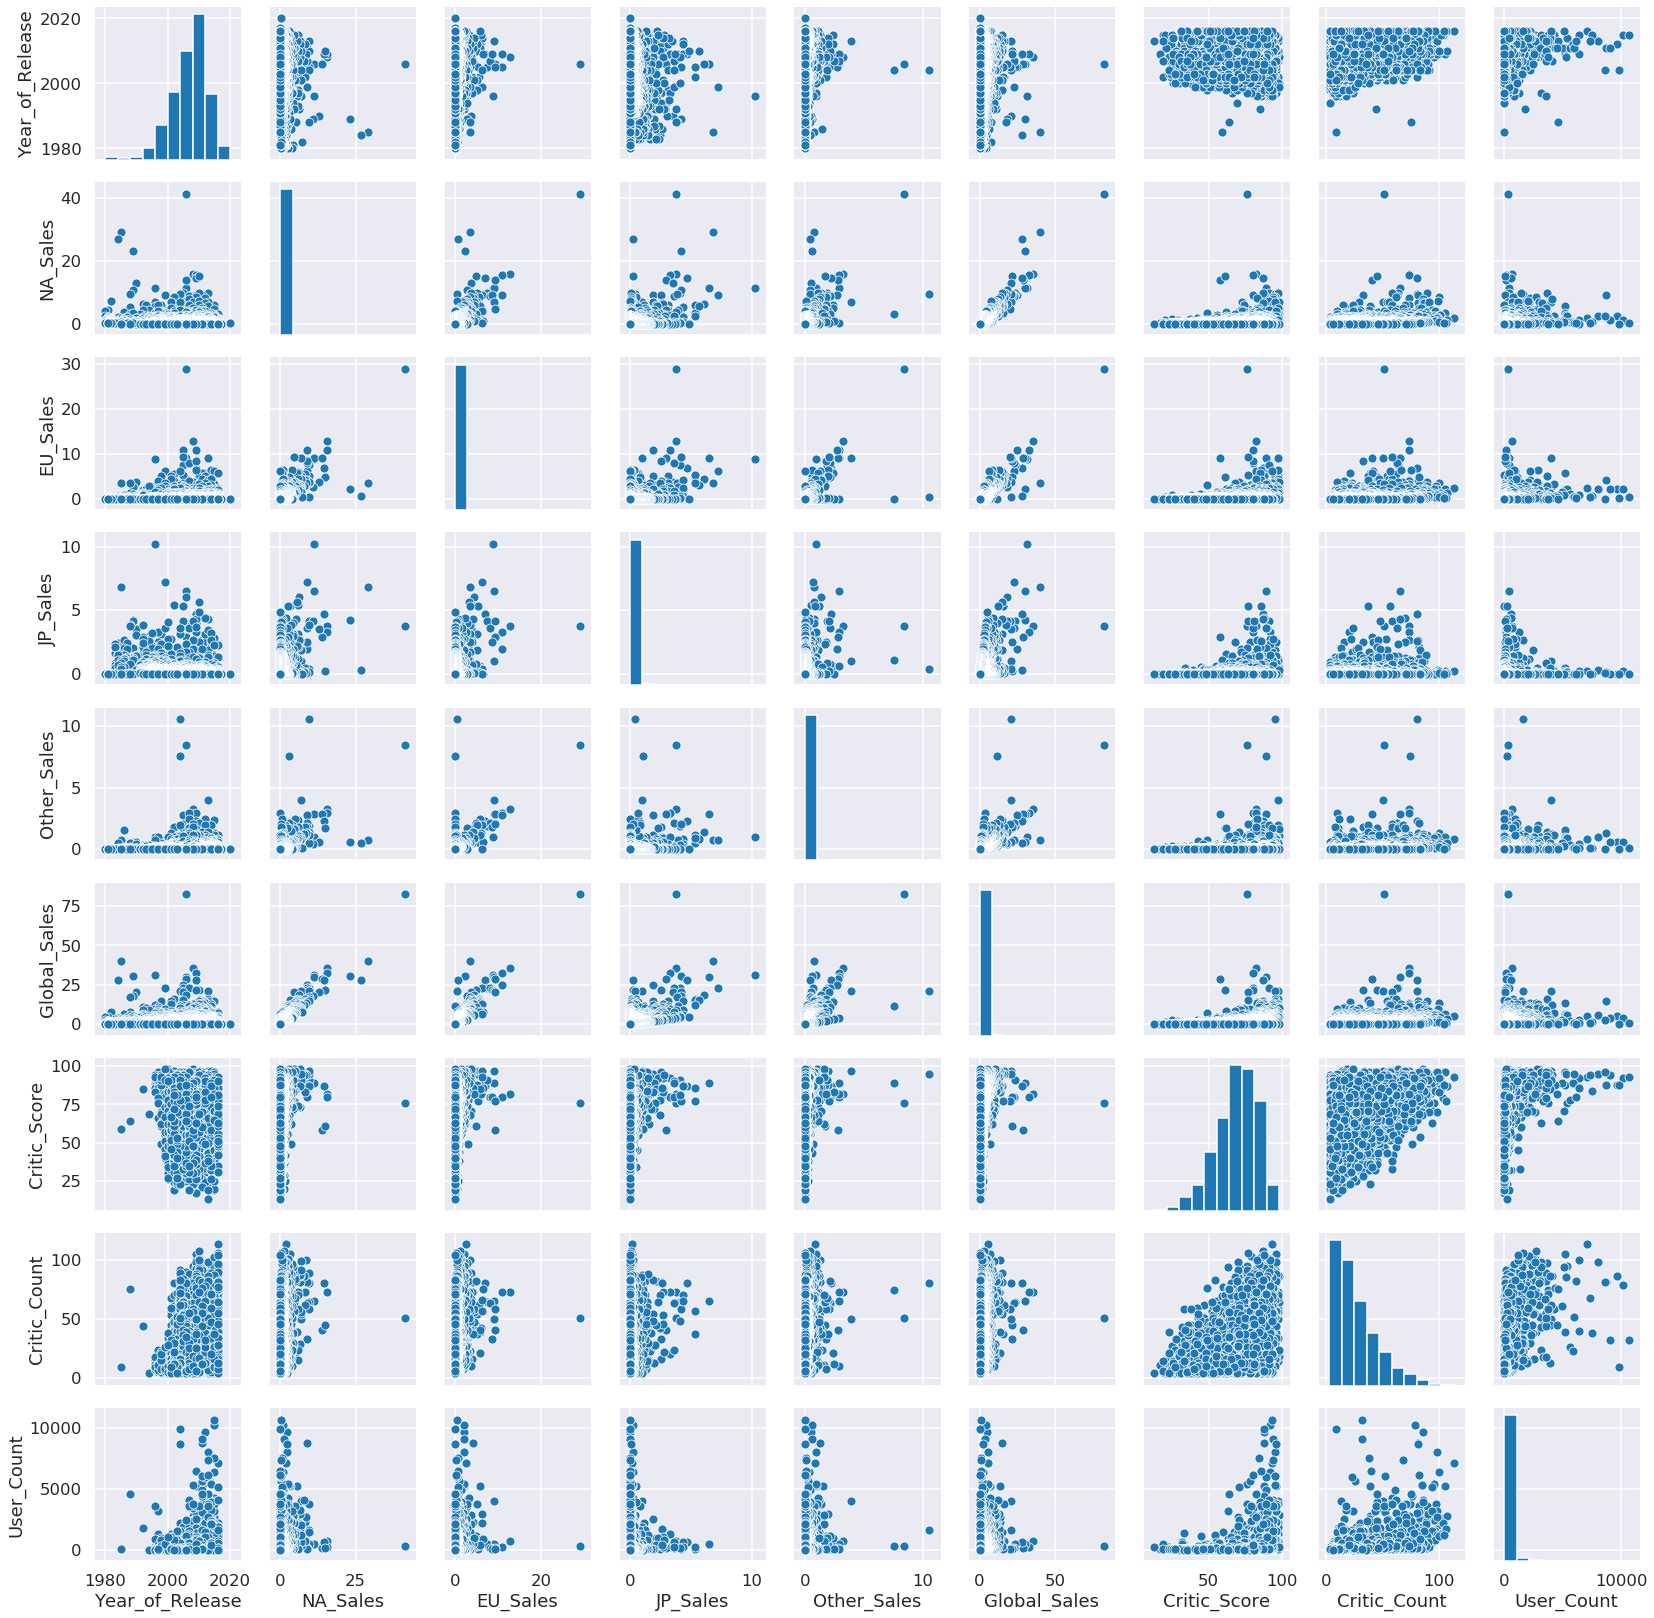

In [12]:
g = sns.pairplot(dataDF)

## Preparar_datos

Es común construir modelos de regresión para predecir el número de unidades y los ingresos por concepto de venta de un producto. En el caso que nuestro dataset consista de series de tiempo, en principio es posible construir un modelo de regresión.

En este caso no contamos con las ventas separadas por mes o cuatrimestre, por lo cual el modelo de regresión no sería muy confiable. Abordaremos este problema como uno de clasificación y definiremos la columna "hit" para definir un juego que fue exitoso comercialmente.

Es necesario definir un valor de corte, por ahora usaremos el valor de 1 millón para definir si un juego fue exitoso.

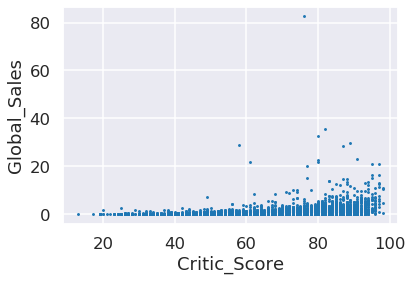

In [13]:
dataDF.plot(kind='scatter', x='Critic_Score', y='Global_Sales', s=2)

In [14]:
dataDF['hit'] = (dataDF['Global_Sales'] > 1)
dataDF.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating,hit
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E,True
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN,True
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E,True
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E,True
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN,True


In [15]:
dataDF['hit'].value_counts()

False    14662
True      2057
Name: hit, dtype: int64

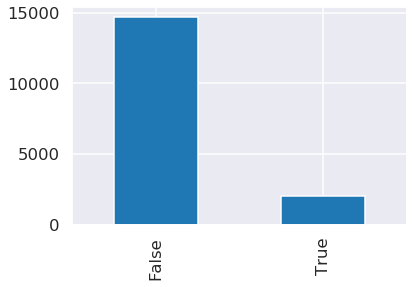

In [16]:
dataDF['hit'].value_counts().plot.bar()

Eliminamos las columnas que no aportarán información en la construccion del modelo y aquellas que tienen alta colinearidad con Global_Sales

In [44]:
dataProcDF = dataDF.drop(['Name', 'Year_of_Release', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Count', 'User_Count', 'Developer'], axis=1)
dataProcDF.head()

,Platform,Genre,Publisher,Critic_Score,User_Score,Rating,hit
0,Wii,Sports,Nintendo,76.0,8,E,True
1,NES,Platform,Nintendo,NaN,NaN,NaN,True
2,Wii,Racing,Nintendo,82.0,8.3,E,True
3,Wii,Sports,Nintendo,80.0,8,E,True
4,GB,Role-Playing,Nintendo,NaN,NaN,NaN,True


In [45]:
len(dataProcDF)

16719

Contamos el número de registros faltantes por cada columna

In [46]:
dataProcDF.isnull().sum()

Platform           0
Genre              2
Publisher         54
Critic_Score    8582
User_Score      6704
Rating          6769
hit                0
dtype: int64

Si bien existen múltiples maneras de imputar datos, en este caso optaremos simplemente por eliminar los registros que tienne al menos un NaN

In [47]:
dataProcDF = dataProcDF.dropna()

In [48]:
len(dataProcDF)

8021

Examinamos los tipos de datos de las columnas

In [49]:
dataProcDF.dtypes

Platform         object
Genre            object
Publisher        object
Critic_Score    float64
User_Score       object
Rating           object
hit                bool
dtype: object

Es interesante notar que User_Score es del tipo object y no del tipo numérico. Revisemos que tipos de valores tiene

In [50]:
dataProcDF['User_Score'].unique()

array(['8', '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4', '8.2',
       '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2', '8.9',
       '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3', '7.6',
       '5.7', '5', '9.1', '6.5', '8.8', '6.9', '9.4', '6.8', '6.1', '6.7',
       '5.4', '4', '9.3', '6.2', '4.2', '6', 'tbd', '4.9', '3.7', '4.1',
       '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9', '3.1', '2.9',
       '5.2', '3.3', '4.5', '5.1', '3.5', '2.5', '1.9', '2.2', '2', '9.5',
       '4.7', '2.1', '3.6', '1.8', '3.8', '3', '9.6', '2.8', '1.7', '2.7',
       '2.4', '1.5', '1.2', '2.3', '0.5', '0.6', '0.9', '1', '1.4', '1.3',
       '0.7'], dtype=object)

Notamos que los valores son de tipo string y que está la abreviación tbd de "To be defined". Para solucionar este problema, usaremos los valores de Critc_Score para reemplazar los valores de tbd de User_Score.

Recordar que los valores de la critica van de 1 a 100

In [51]:
dataProcDF['User_Score'] = dataProcDF['User_Score'].apply(pd.to_numeric, errors='coerce')
dataProcDF['User_Score'] = dataProcDF['User_Score'].mask(np.isnan(dataProcDF["User_Score"]), dataProcDF['Critic_Score'] / 10.0)

In [52]:
dataProcDF.dtypes

Platform         object
Genre            object
Publisher        object
Critic_Score    float64
User_Score      float64
Rating           object
hit                bool
dtype: object

Finalemnte, transformamos todas las variables categoricas en binarias. Para ello usaremos el metodo de one-hot encoding

In [53]:
if dataProcDF['hit'].dtype == bool:
    dataProcDF['hit'] = dataProcDF['hit'].apply(lambda y: 'yes' if y == True else 'no')
    
dataProcDF = pd.get_dummies(dataProcDF)
dataProcDF.head()

,Critic_Score,User_Score,Platform_3DS,Platform_DC,Platform_DS,Platform_GBA,Platform_GC,Platform_PC,Platform_PS,Platform_PS2,...,Publisher_inXile Entertainment,Rating_AO,Rating_E,Rating_E10+,Rating_K-A,Rating_M,Rating_RP,Rating_T,hit_no,hit_yes
0,76.0,8.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,82.0,8.3,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
3,80.0,8.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
6,89.0,8.5,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
7,58.0,6.6,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


In [102]:
len(dataProcDF)

8021

## Separacion de train y test

Separamos el dataset en train, validation y test. Luego los subimos al bucket de S3

In [68]:
from sklearn.datasets import dump_svmlight_file   
from sklearn.model_selection import train_test_split

import sagemaker

In [69]:
sagemaker.__version__

'1.72.1'

In [55]:
#bucket = sagemaker.Session().default_bucket()
bucket = 'taller-copec'
prefix = 'sagemaker/videogames-xgboost'
role = sagemaker.get_execution_role()

print('Bucket:\n{}'.format(bucket))

Bucket:
taller-copec


In [107]:
train_data, validation_data, test_data = np.split(dataProcDF.sample(frac=1, random_state=1729), [int(0.7 * len(dataProcDF)), int(0.9 * len(dataProcDF))])   

In [108]:
print(len(train_data))
print(len(validation_data))
print(len(test_data))

5614
1604
803


El metodo XGBoost de SageMaker soporta la ingesta de datos en formato CSV y libSVM.  Usaremos el formato libSVM aqui, donde los features y la variable objetivo se entregan como argumentos por separado.

Subimos los archivos resultantes al bucket de S3.

In [73]:
dump_svmlight_file(X=train_data.drop(['hit_no', 'hit_yes'], axis=1), y=train_data['hit_yes'], f='data/train.libsvm')
dump_svmlight_file(X=validation_data.drop(['hit_no', 'hit_yes'], axis=1), y=validation_data['hit_yes'], f='data/validation.libsvm')
dump_svmlight_file(X=test_data.drop(['hit_no', 'hit_yes'], axis=1), y=test_data['hit_yes'], f='data/test.libsvm')

boto3.Session().resource('s3').Bucket(bucket).Object(prefix + '/train/train.libsvm').upload_file('data/train.libsvm')
boto3.Session().resource('s3').Bucket(bucket).Object(prefix + '/validation/validation.libsvm').upload_file('data/validation.libsvm')

Almacenamos en un objeto de Python los datasets de entrenamiento y validación que dejamos en S3

In [67]:
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket, prefix), content_type='libsvm')
s3_input_validation = sagemaker.s3_input(s3_data='s3://{}/{}/validation/'.format(bucket, prefix), content_type='libsvm')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.
's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


In [62]:
s3_input_train.config

{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix',
   'S3Uri': 's3://taller-copec/sagemaker/videogames-xgboost/train',
   'S3DataDistributionType': 'FullyReplicated'}},
 'ContentType': 'libsvm'}

In [63]:
s3_input_validation.config

{'DataSource': {'S3DataSource': {'S3DataType': 'S3Prefix',
   'S3Uri': 's3://taller-copec/sagemaker/videogames-xgboost/validation/',
   'S3DataDistributionType': 'FullyReplicated'}},
 'ContentType': 'libsvm'}

---
## Entrenamiento

Nuestros datos ahora están listos para usarse para entrenar un modelo XGBoost. El algoritmo XGBoost tiene muchos hiperparámetros ajustables. Algunos de estos hiperparámetros se enumeran a continuación; inicialmente solo usaremos algunos de ellos.

- `max_depth`: Profundidad máxima de un árbol. Como nota de advertencia, un valor demasiado pequeño podría no adaptarse a los datos, mientras que aumentarlo hará que el modelo sea más complejo y, por lo tanto, es más probable que se sobreajuste a los datos (en otras palabras, el clásico equilibrio sesgo-varianza).
- `eta`: Reducción del tamaño del paso utilizada en las actualizaciones para evitar el sobreajuste.
- `eval_metric`: Métricas de evaluación para datos de validación. Para conjuntos de datos como este con clases desequilibradas, usaremos la métrica AUC.
- `scale_pos_weight`: Controla el equilibrio de ponderaciones positivas y negativas, de nuevo útil para conjuntos de datos que tienen clases desequilibradas.

Primero, configuraremos los parámetros para un objeto Estimador de Amazon SageMaker y los hiperparámetros para el algoritmo en sí. El objeto Estimator del SDK de Python de Amazon SageMaker es una forma conveniente de configurar trabajos de entrenamiento con una cantidad mínima de código.

In [70]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, 'xgboost')

xgb = sagemaker.estimator.Estimator(container,
                                    role, 
                                    base_job_name='videogames-xgboost',
                                    train_instance_count=1, 
                                    train_instance_type='ml.c5.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sagemaker.Session())

xgb.set_hyperparameters(max_depth=3,
                        eta=0.1,
                        subsample=0.5,
                        eval_metric='auc',
                        objective='binary:logistic',
                        scale_pos_weight=2.0,
                        num_round=100)


'get_image_uri' method will be deprecated in favor of 'ImageURIProvider' class in SageMaker Python SDK v2.
There is a more up to date SageMaker XGBoost image. To use the newer image, please set 'repo_version'='1.0-1'. For example:
	get_image_uri(region, 'xgboost', '1.0-1').
Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


A continuación, ejecutaremos el trabajo de entrenamiento alojado.

El hardware que se utiliza para el trabajo de entrenamiento es independiente de la instancia de su notebook y lo administra Amazon SageMaker, que realiza el trabajo pesado, como configurar un clúster de entrenamiento y desmontarlo cuando el trabajo está terminado. Una sola línea de código inicia el trabajo de entrenamiento.

Más info en Más info en https://sagemaker.readthedocs.io/en/stable/overview.html

In [71]:
xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

2020-10-27 17:41:15 Starting - Starting the training job...
2020-10-27 17:41:21 Starting - Launching requested ML instances......
2020-10-27 17:42:32 Starting - Preparing the instances for training...
2020-10-27 17:43:11 Downloading - Downloading input data...
2020-10-27 17:43:43 Training - Training image download completed. Training in progress..Arguments: train
[2020-10-27:17:43:43:INFO] Running standalone xgboost training.
[2020-10-27:17:43:43:INFO] File size need to be processed in the node: 0.24mb. Available memory size in the node: 78.81mb
[17:43:43] S3DistributionType set as FullyReplicated
[17:43:43] 5614x331 matrix with 33684 entries loaded from /opt/ml/input/data/train
[17:43:43] S3DistributionType set as FullyReplicated
[17:43:43] 1604x331 matrix with 9624 entries loaded from /opt/ml/input/data/validation
[17:43:43] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 14 extra nodes, 0 pruned nodes, max_depth=3
[0]#011train-auc:0.782974#011validation-auc:0.769788
[17:43:

---
## Deployment

Ahora que hemos entrenado el algoritmo XGBoost en nuestros datos, podemos implementar el modelo entrenado en un punto final alojado en Amazon SageMaker con una simple línea de código.

Más info en https://sagemaker.readthedocs.io/en/stable/overview.html

In [74]:
xgb_predictor = xgb.deploy(initial_instance_count=1,
                           instance_type='ml.m5.large')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


-------------!

In [75]:
xgb_predictor.endpoint

'videogames-xgboost-2020-10-27-17-41-15-520'

---

## Evaluacion

Ahora que tenemos nuestro endpoint alojado, podemos generar predicciones a partir de él. Más específicamente, generemos predicciones a partir de nuestro conjunto de datos de prueba para comprender qué tan bien nuestro modelo se generaliza a datos que aún no ha visto.

Hay muchas formas de comparar el rendimiento de un modelo de aprendizaje automático. Comenzaremos simplemente comparando los valores reales con los predichos de si el juego fue un "acierto" (`1`) o no (` 0`). Luego, produciremos una matriz de confusión, que muestra cuántos puntos de datos de prueba predijo el modelo en cada categoría frente a cuántos puntos de datos de prueba pertenecían realmente a cada categoría.

In [79]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [80]:
xgb_predictor.content_type = 'text/x-libsvm'
xgb_predictor.deserializer = None

def do_predict(data):
    payload = '\n'.join(data)
    response = xgb_predictor.predict(payload).decode('utf-8')
    result = response.split(',')
    preds = [float((num)) for num in result]
    preds = [round(num) for num in preds]
    return preds

def batch_predict(data, batch_size):
    items = len(data)
    arrs = []
    
    for offset in range(0, items, batch_size):
        if offset+batch_size < items:
            results = do_predict(data[offset:(offset+batch_size)])
            arrs.extend(results)
        else:
            arrs.extend(do_predict(data[offset:items]))
        sys.stdout.write('.')
    return(arrs)

In [89]:
%%time
import json

with open('data/test.libsvm', 'r') as f:
    payload = f.read().strip()

yTest = [int(line.split(' ')[0]) for line in payload.split('\n')]
xTest = [line for line in payload.split('\n')]
yPred = batch_predict(xTest, 100)

print ('\nerror rate=%f' % ( sum(1 for i in range(len(yPred)) if yPred[i]!=yTest[i]) /float(len(yPred))))

.........
error rate=0.134496
CPU times: user 45 ms, sys: 8.35 ms, total: 53.3 ms
Wall time: 255 ms


Analisis de matriz de confusion

In [90]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues,
                          figFile='model_confussion_matrix.jpg'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(len(classes)))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

#     print(cm)

    fig, ax = plt.subplots(figsize=(10,10))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    ax.tick_params(labelbottom=False, labeltop=True, labelright=False, )

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=60, ha="left",
             rotation_mode="anchor")
    '''
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    '''
    fig.tight_layout()
    
    figFile = os.path.join(resultsDir, figFile)
    fig.savefig(figFile, dpi=300)

In [112]:
labels = ['Negative', 'Positive']
cm = confusion_matrix(yTest, yPred, labels=[0, 1])

cm

array([[622,  49],
       [ 59,  73]])

In [113]:
test_data.groupby('hit_yes').size()

hit_yes
0    671
1    132
dtype: int64

En el dataset de test habian 132 juegos en la categoria de hit.
Podemos ver que 59 juegos que eran realmente hit fueron mal clasificados como no_hit y que 73 sí fueron clasificados correctamente como hit

Normalized confusion matrix


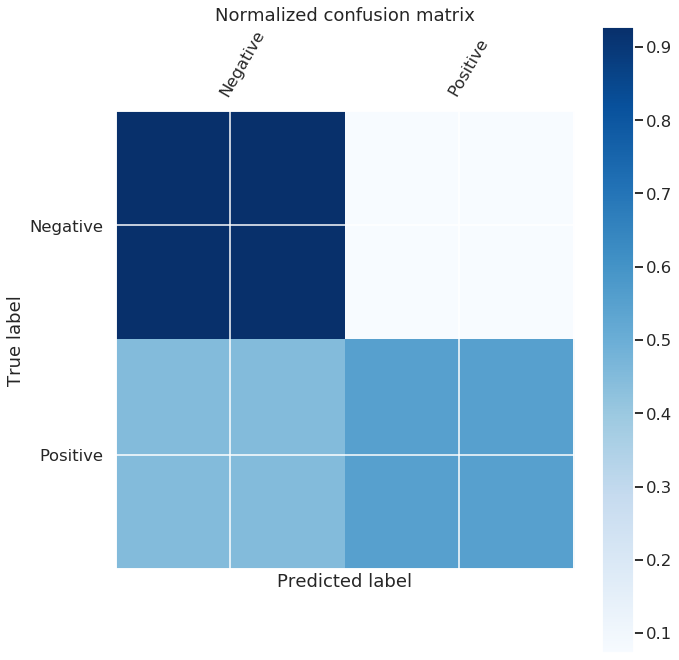

In [114]:
plot_confusion_matrix(yTest, yPred, labels, normalize=True)

In [115]:
print(classification_report(yTest, yPred))

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       671
           1       0.60      0.55      0.57       132

    accuracy                           0.87       803
   macro avg       0.76      0.74      0.75       803
weighted avg       0.86      0.87      0.86       803



Of the 132 games in the test set that actually are "hits" by our metric, the model correctly identified over 70, while the overall error rate is 13%.  The amount of false negatives versus true positives can be shifted substantially in favor of true positives by increasing the hyperparameter scale_pos_weight. Of course, this increase comes at the expense of reduced accuracy/increased error rate and more false positives. How to make this trade-off ultimately is a business decision based on the relative costs of false positives, false negatives, etc.

---
## Cleanup

Si ha terminado con este cuaderno, ejecute la celda a continuación. Esto eliminará el punto final alojado que creó y evitará cualquier cargo por dejar una instancia perdida.

In [116]:
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)